# Resonate-and-Fire Neuron Model

The Resonate-and-Fire (RF) neuron model extends beyond the passive membrane dynamics of leaky integrate-and-fire models by incorporating resonant properties. While LIF models behave like an RC circuit (resistor-capacitor), the RF model behaves like an RLC circuit (resistor-inductor-capacitor), enabling frequency-selective responses. LIF is a single differential equation whilst RAF is a second-order differential equation.

## Key Properties

1. **Subthreshold Resonance**: The model can oscillate at a preferred frequency in response to inputs
2. **Post-inhibitory Rebound**: Can generate spikes after inhibitory input
3. **Phase-dependent Responsiveness**: Sensitivity to input depends on oscillation phase
4. **Frequency Selectivity**: Responds more strongly to inputs at its resonant frequency

## Mathematical Description

The model is described by two coupled differential equations:

dV/dt = (-(V - V_rest) + R·I - U)/τ_m
dU/dt = (-(U) + a(V - V_rest))/τ_r

When V ≥ V_th:
  • V is reset to V_reset
  • U remains unchanged

The resonant frequency (f) is determined by:
f = (1/2π)·√(a/τ_m·τ_r - 1/4·(1/τ_m - 1/τ_r)²)

Parameters:
- V: Membrane potential
- U: Resonance variable (acts like a virtual inductance)
- V_rest: Resting potential (typically -70 mV)
- V_th: Spike threshold (typically -50 mV)
- V_reset: Reset potential (typically -70 mV)
- R: Membrane resistance (typically 10 MΩ)
- τ_m: Membrane time constant (typically 10-30 ms)
- τ_r: Resonance time constant (typically 50-200 ms)
- a: Resonance strength parameter (typically 0.1-0.5)
- I: Input current

State Variables:
- V: Membrane potential (initialize at V_rest)
- U: Resonance variable (initialize at 0)

Time-related variables:
- dt: Time step for numerical integration
- t: Current simulation time
- tmax: Maximum simulation time

## Algorithm

1. Initialize state variables
   - V = V_rest (resting potential)
   - U = 0
   - Create empty list for spike times

2. For each time step from t=0 to t=tmax:
   
   a. Check if spike threshold is reached
      - If V ≥ V_th:
        • Record spike time
        • Reset membrane potential: V = V_reset
        • U remains unchanged (unlike adaptation models)
   
   b. Compute derivative terms
      - dV/dt = (-(V - V_rest) + R·I - U)/τ_m
      - dU/dt = (-(U) + a(V - V_rest))/τ_r
   
   c. Update state variables using Euler method
      - V = V + dV/dt * dt
      - U = U + dU/dt * dt
   
   d. Store variables for plotting
      - Record V, U at current time step
   
   e. Increment time: t = t + dt

3. Analyze and visualize results
   - Plot membrane potential (V) vs time
   - Plot resonance variable (U) vs time
   - Create phase portrait (V vs U)
   - Analyze frequency response

## Characteristic Behaviors

1. **Damped Oscillations**: When perturbed and left without input, the membrane potential shows damped oscillations
2. **Frequency Selectivity**: Maximum response amplitude occurs when input frequency matches resonant frequency
3. **Phase-Reset**: Brief pulses can reset the phase of ongoing oscillations
4. **Rebound Spiking**: Can generate spikes following hyperpolarizing currents (inhibition)
5. **Coincidence Detection**: Enhanced response to properly timed inputs arriving at specific phases

## Biological Mechanisms Represented

The resonance behavior represents:
- Hyperpolarization-activated cyclic nucleotide-gated (HCN) channels
- M-type potassium currents that activate slowly with depolarization
- Interactions between fast sodium and delayed rectifier potassium currents
- T-type calcium channels that contribute to rebound excitation
- Intrinsic properties that enable neurons to participate in network oscillations

## Applications

The resonate-and-fire model is particularly useful for modeling:
- Neurons with subthreshold membrane potential oscillations
- Thalamic relay neurons with rebound bursting properties
- Auditory neurons with frequency selectivity
- Neural circuits involved in rhythm generation and synchronization
- Hippocampal and cortical neurons with resonant properties

In [5]:
class RAF():
    def __init__(self, Cm, R, V_th, V_reset, V_rest, I, time_steps, tau_w=5, a=0.1, b=0.2):
        self.Cm = Cm  # Membrane capacitance
        self.R = R    # Membrane resistance
        self.V_th = V_th  # Threshold voltage
        self.V_reset = V_reset  # Reset voltage
        self.V_rest = V_rest  # Resting voltage
        self.I = I    # Input current
        self.tau = R * Cm  # Membrane time constant
        
        # Resonance parameters
        self.tau_w = tau_w  # Time constant for resonance variable
        self.a = a  # Parameter controlling resonance strength
        self.b = b  # Parameter controlling resonance frequency
        
        self.time_steps = time_steps

    def raf(self):
        # Initialize arrays for storing voltage, resonance variable, and spike times
        voltage = [self.V_reset]  # Start at reset voltage
        w = [0]  # Resonance variable (starts at 0)
        spikes = []
        dt = self.time_steps[1] - self.time_steps[0]  # Time step size
        
        # Simulate for each time step
        for t_idx, t in enumerate(self.time_steps[:-1]):
            # Current values
            V_current = voltage[-1]
            w_current = w[-1]
            
            # Differential equations for resonate-and-fire model
            # dV/dt = (I + a*V - w)/tau
            # dw/dt = (b*V - w)/tau_w
            
            # Update membrane potential using Euler method
            dV = ((self.I + self.a * (V_current - self.V_rest) - w_current) / self.tau) * dt
            V_next = V_current + dV
            
            # Update resonance variable
            dw = ((self.b * (V_current - self.V_rest) - w_current) / self.tau_w) * dt
            w_next = w_current + dw
            
            # Check for spike
            if V_next >= self.V_th:
                spikes.append(t + dt)
                V_next = self.V_reset
                # Note: w is not reset after a spike in the standard model
            
            voltage.append(V_next)
            w.append(w_next)
        
        return voltage, w, spikes
    
    def plot_results(self, voltage, w, spikes):
        import matplotlib.pyplot as plt
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot membrane potential
        ax1.plot(self.time_steps, voltage)
        ax1.axhline(y=self.V_th, color='r', linestyle='--', alpha=0.7, label='Threshold')
        ax1.axhline(y=self.V_reset, color='g', linestyle='--', alpha=0.7, label='Reset')
        
        # Plot spikes as vertical lines on the voltage plot
        for spike in spikes:
            ax1.axvline(x=spike, color='r', linestyle='-', alpha=0.5)
        
        ax1.set_ylabel('Membrane Potential (mV)')
        ax1.set_title('Resonate-and-Fire Neuron')
        ax1.legend()
        ax1.grid(True)
        
        # Plot resonance variable
        ax2.plot(self.time_steps, w, color='purple')
        ax2.set_xlabel('Time (ms)')
        ax2.set_ylabel('Resonance Variable (w)')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

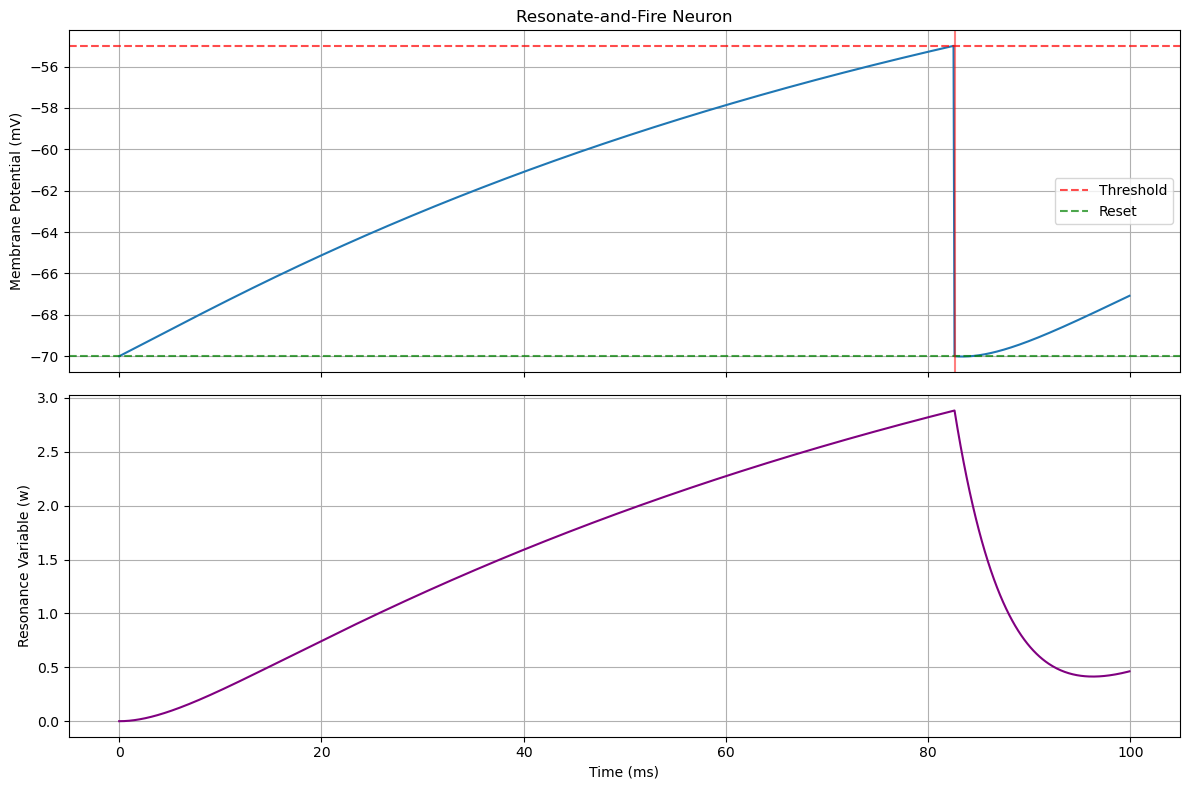

In [6]:
# Simulation parameters
t_max = 100  # ms
dt = 0.1  # ms
time_steps = np.arange(0, t_max, dt)

# Create resonate-and-fire neuron
rf_neuron = RAF(
    Cm=1,           # nF
    R=10,           # MΩ
    V_th=-55,       # mV
    V_reset=-70,    # mV
    V_rest=-70,     # mV
    I=2.5,          # nA
    time_steps=time_steps,
    tau_w=5,        # ms, resonance time constant
    a=0.1,          # Dimensionless parameter controlling resonance strength
    b=0.2           # Dimensionless parameter controlling resonance frequency
)

# Run simulation
voltage, w, spikes = rf_neuron.raf()

# Plot results
rf_neuron.plot_results(voltage, w, spikes)